### Yelp Sentiment Analysis


In [1]:
# Import the Required Libraries, after installing the required packages in the virtual env
import transformers 
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from collections import defaultdict
import time

In [2]:
# Download NLTK stopwords and punkt that would be used for preprocessing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohitsarin26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/mohitsarin26/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the requried dataset
train_data = pd.read_csv('yelp_review_train.csv')
test_data = pd.read_csv('yelp_review_test.csv')

In [5]:
train_data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [6]:
test_data.head()

,text,stars
0,"Hidden treasure! Awesome service, delicious fo...",5.0
1,My family and I have been patients since I wa...,5.0
2,"I rarely get pedicures, but Blue Nail's practi...",5.0
3,"We came with a large group, may of the items w...",2.0
4,The view is great from Morgan's Pier. The bart...,2.0


In [1]:
# Preprocessing the data and converting stars into three levels, such that 
#  Positive > 3, negative <= 2, and neutral = 3.

In [7]:
# Function to pre-process text 
def data_preprocessing(text):
    # Remove HTML tags and special characters from the text field 
    text = re.sub('<[^<]+?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization of the text fields and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply pre-processing to the 'text' column
train_data['text'] = train_data['text'].apply(data_preprocessing)
test_data['text'] = test_data['text'].apply(data_preprocessing)

# Convert stars to three levels
train_data['sentiment'] = train_data['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))
test_data['sentiment'] = test_data['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))

# Define Level names
levels = ['Negative', 'Neutral', 'Positive']
# Mapping dictionary for sentiment labels
level_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}

# Convert sentiment column to integers based on the mapping
train_data['sentiment'] = train_data['sentiment'].map(level_mapping)
test_data['sentiment'] = test_data['sentiment'].map(level_mapping)

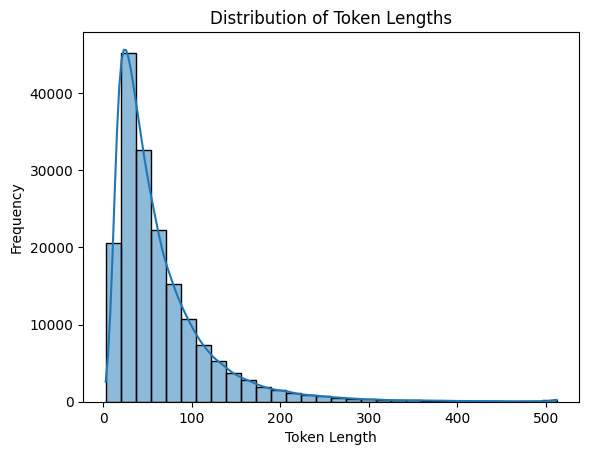

Mean Token Length: 64.82734311071945
Median Token Length: 47.0
Maximum Token Length: 512
Minimum Token Length: 3


In [8]:
# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate token lengths
token_lens = [len(tokenizer.encode(txt, max_length=512, truncation=True)) for txt in train_data.text]

# Plot histogram
sns.histplot(token_lens, bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Display mean and median values
mean_length = np.mean(token_lens)
median_length = np.median(token_lens)
max_length = np.max(token_lens)
min_length = np.min(token_lens)
print(f"Mean Token Length: {mean_length}")
print(f"Median Token Length: {median_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")

In [9]:
# Defining MAX_LEN globally
MAX_LEN = 120

# Creating a class for processing the data
class processdata(Dataset):
    
    def __init__(self,text,targets,tokenizer,max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self,item):
        review = str(self.text[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review, add_special_tokens=True, max_length=self.max_len, return_token_type_ids=False,
            padding='max_length', truncation=True,
            return_attention_mask=True,
            return_tensors='pt',)
        
        return {'review_text': review, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}
    
    def __len__(self):
        return len(self.text)

    

In [ ]:
# Here, we have implemented the BERT model and performed hyperparameter tuning.

### Model-1
**Hyperparametes Discussion**: For this model, I'm using the BERTsmall pre-trained model with 12 layers, freezing the first 8 layers of the BERT model, and updating the weights of the last 4 layers during training. This fine-tuning helps the model extract features that are specific to our dataset. After that, I added a dropout layer with a probability of 0.4, a fully connected layer, and a batch normalization layer. Additionally, I have utilized a block of layers, including Dropout, ReLU, and a Linear layer of size (128,3). Furthermore, we have set the max token length value to 120, and the batch size to 32. Keeping the batch size small is necessary to observe how the model performs in the initial stages of training. Also, Mini Batch Gradient Descent is required as per the question; hence, training of the model followed this procedure using SGD optimizer. The initial learning rate of 0.001 was kept low so that the model learns effectively. The learning rate was updated in every epoch. The total number of epochs was fixed at 10 for this model, as 10 epochs are deemed sufficient for the model to generalize, given the utilization of a pre-trained BERT unit in the model.
    

In [10]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict = False)

class classifier(nn.Module):
    def __init__(self, n_classes, freeze_layers=4):  
        super(classifier, self).__init__()
        self.bert = bert_model
        
        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Unfreeze the last 4 layers
        for layer in self.bert.encoder.layer[-freeze_layers:]:
            for param in layer.parameters():
                param.requires_grad = True
                
        self.drop = nn.Dropout(p=0.4)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.layer_norm = nn.LayerNorm(128) 
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask)
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)


In [11]:
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)
test_set = test_data

def dataloader(df,tokenizer,max_len,batch_size):
    datal = processdata(
        text = df.text.to_numpy(), 
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(datal,batch_size=batch_size,num_workers=4)

BATCH_SIZE = 32
train_data_loader = dataloader(train_set, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = dataloader(val_set, tokenizer, MAX_LEN, BATCH_SIZE)

model1 = classifier(len(levels))
model1 = model1.to(device)
total_epochs = 10
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001)
total_steps = len(train_data_loader) * total_epochs
loss_scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_function = nn.CrossEntropyLoss().to(device)

In [12]:
def training(model1,data_loader,loss_function,optimizer,device,loss_scheduler, examples):
    model1 = model1.train()
    losses = []
    model_prediction = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model1(
            input_ids=input_ids,
            attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs,targets)

        model_prediction += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)
        optimizer.step()
        loss_scheduler.step()
        optimizer.zero_grad()

    return model_prediction.double() / examples, np.mean(losses)


In [13]:
def eval_model1(model1, data_loader, loss_function, device, examples):
    model1 = model1.eval()
    losses = []
    model_prediction = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model1(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)
            model_prediction += torch.sum(preds == targets)
            losses.append(loss.item())
    return model_prediction.double() / examples, np.mean(losses)

In [14]:
history = defaultdict(list)

for epoch in range(total_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{total_epochs}')
    print('-' * 20)

    # Training
    train_accuracy, train_loss = training(
        model1,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        loss_scheduler,
        len(train_set)
    )
    print(f'Training Loss {train_loss} Accuracy {train_accuracy}')

    # Validation
    val_accuracy, val_loss = eval_model1(
        model1,
        val_data_loader,
        loss_function,
        device,
        len(val_set)
    )
    print(f'Validation Loss {val_loss} Accuracy {val_accuracy}')

    # Calculate and print epoch running time
    epoch_time = time.time() - start_time
    print(f'Epoch time: {epoch_time:.2f} seconds')

    print()
    history['train_accuracy'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss)        

# Save the final validation accuracy for model1
model1 = model1
model1_final_val_accuracy = val_accuracy
model1_name = 'model1'


Epoch 1/10
--------------------
Training Loss 0.6656766555713935 Accuracy 0.7522048567647796
Validation Loss 0.5075018941429047 Accuracy 0.8172636758983749
Epoch time: 437.25 seconds

Epoch 2/10
--------------------
Training Loss 0.5160943550085634 Accuracy 0.8197489360180251
Validation Loss 0.46410130506955694 Accuracy 0.831769283588922
Epoch time: 426.88 seconds

Epoch 3/10
--------------------
Training Loss 0.48204632368110145 Accuracy 0.8289975322771003
Validation Loss 0.4452675545395566 Accuracy 0.8365758754863813
Epoch time: 426.94 seconds

Epoch 4/10
--------------------
Training Loss 0.46618624168993217 Accuracy 0.83120060083688
Validation Loss 0.43640739780877125 Accuracy 0.8382639047837034
Epoch time: 426.78 seconds

Epoch 5/10
--------------------
Training Loss 0.45508461810169243 Accuracy 0.8339043667966096
Validation Loss 0.4279231124123846 Accuracy 0.8400377660791943
Epoch time: 427.28 seconds

Epoch 6/10
--------------------
Training Loss 0.4508093756641259 Accuracy 0.83

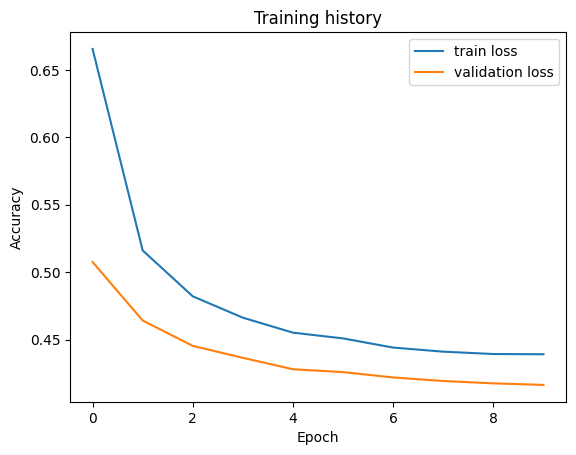

In [15]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


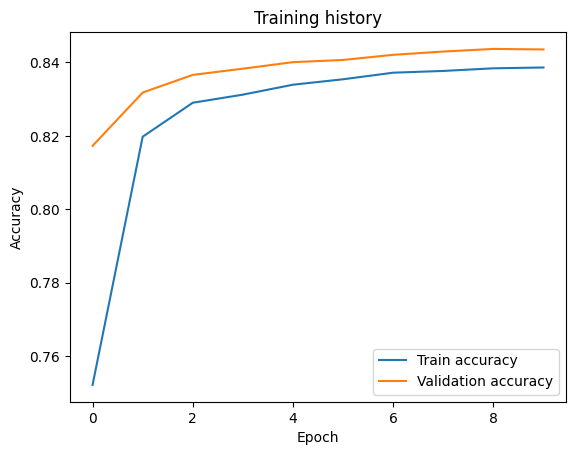

In [16]:
training_accuracy = [acc.item() for acc in history['train_accuracy']]
validation_accuracy = [acc.item() for acc in history['val_accuracy']]
plt.plot(training_accuracy, label='Train accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

### Model-2
Here, we are repeating the steps from loading the data to training the model for the Model 2.

**Model-2**: 
**Hyperparameters Discussion**: The validation accuracy for Model 1 is approximately 84%, but I believe the model should achieve higher accuracy given the utilization of features from the pre-trained BERT model. Therefore, I decided to experiment with adjusting few of the hyperparameters. In this model, the BERT model configuration remains the same as the first model, with the last 4 layers unfrozen. Subsequently, a dropout layer with a probability of 0.4, a fully connected layer, and a batch normalization layer were added. Furthermore, a block of layers, including Dropout, and ReLU was employed. To enable the model to learn more specific features, an additional fully connected layer of size (128,64) was introduced, followed by a batch normalization layer, dropout, and a ReLU layer. Finally, the model includes a Linear(64,3) layer.
Moreover, the max token length value was adjusted to 100 to explore whether this modification would yield better results, especially considering that the median length of tokens is below 50. Additionally, to assess different batch size configurations, the batch size was increased to 64. Adhering to the requirement for Mini Batch Gradient Descent, the training of the model followed this procedure. The initial learning rate of 0.001 was deliberately kept low to ensure effective learning. The learning rate was updated in every epoch. After experimenting with 10 epochs in Model 1, I observed minimal change in validation accuracy beyond the 7th and 8th epochs. Consequently, for
this model, I opted for 8 epochs.

In [17]:
# Load the requried dataset
train_data = pd.read_csv('yelp_review_train.csv')
test_data = pd.read_csv('yelp_review_test.csv')

In [18]:
# Function to pre-process text 
def data_preprocessing(text):
    # Remove HTML tags and special characters from the text field 
    text = re.sub('<[^<]+?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization of the text fields and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply pre-processing to the 'text' column
train_data['text'] = train_data['text'].apply(data_preprocessing)
test_data['text'] = test_data['text'].apply(data_preprocessing)

# Convert stars to three levels
train_data['sentiment'] = train_data['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))
test_data['sentiment'] = test_data['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))

# Define Level names
levels = ['Negative', 'Neutral', 'Positive']
# Mapping dictionary for sentiment labels
level_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}

# Convert sentiment column to integers based on the mapping
train_data['sentiment'] = train_data['sentiment'].map(level_mapping)
test_data['sentiment'] = test_data['sentiment'].map(level_mapping)

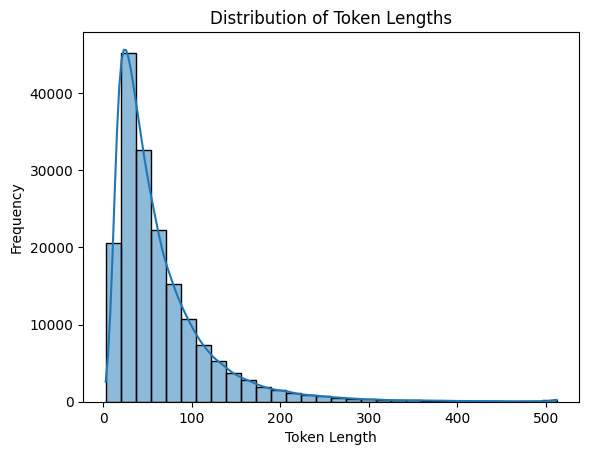

Mean Token Length: 64.82734311071945
Median Token Length: 47.0
Maximum Token Length: 512
Minimum Token Length: 3


In [19]:
# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate token lengths
token_lens = [len(tokenizer.encode(txt, max_length=512, truncation=True)) for txt in train_data.text]

# Plot histogram
sns.histplot(token_lens, bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Display mean and median values
mean_length = np.mean(token_lens)
median_length = np.median(token_lens)
max_length = np.max(token_lens)
min_length = np.min(token_lens)
print(f"Mean Token Length: {mean_length}")
print(f"Median Token Length: {median_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")

In [20]:
# Defining MAX_LEN globally
MAX_LEN = 100

# Creating a class for processing the data
class processdata(Dataset):
    
    def __init__(self,text,targets,tokenizer,max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self,item):
        review = str(self.text[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review, add_special_tokens=True, max_length=self.max_len, return_token_type_ids=False,
            padding='max_length', truncation=True,
            return_attention_mask=True,
            return_tensors='pt',)
        
        return {'review_text': review, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}
    
    def __len__(self):
        return len(self.text)

    

In [21]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict = False)

class classifier(nn.Module):
    def __init__(self, n_classes, freeze_layers=4):  # Assuming BERT has 12 layers
        super(classifier, self).__init__()
        self.bert = bert_model
        
        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Unfreeze the last `freeze_layers` layers
        for layer in self.bert.encoder.layer[-freeze_layers:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        self.drop = nn.Dropout(p=0.4)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.layer_norm1 = nn.LayerNorm(128) 
        self.drop1 = nn.Dropout(p=0.4)
        self.relu1 = nn.ReLU()
        
        # Additional layer
        self.out2 = nn.Linear(128, 64)
        self.layer_norm2 = nn.LayerNorm(64)
        self.drop2 = nn.Dropout(p=0.4)
        self.relu2 = nn.ReLU()
        
        self.out3 = nn.Linear(64, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # First layer
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu1(output)
        output = self.drop1(output)
        
        # Additional layer
        output = self.out2(output)
        output = self.layer_norm2(output)
        output = self.relu2(output)
        output = self.drop2(output)
        
        return self.out3(output)


In [22]:
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)
test_set = test_data

def dataloader(df,tokenizer,max_len,batch_size):
    datal = processdata(
        text = df.text.to_numpy(), 
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(datal,batch_size=batch_size,num_workers=4)

BATCH_SIZE = 64
train_data_loader = dataloader(train_set, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = dataloader(val_set, tokenizer, MAX_LEN, BATCH_SIZE)

model2 = classifier(len(levels))
model2 = model2.to(device)
total_epochs = 8
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001)
total_steps = len(train_data_loader) * total_epochs
loss_scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_function = nn.CrossEntropyLoss().to(device)

In [23]:
def training(model2,data_loader,loss_function,optimizer,device,loss_scheduler, examples):
    model2 = model2.train()
    losses = []
    model_prediction = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model2(
            input_ids=input_ids,
            attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs,targets)

        model_prediction += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        optimizer.step()
        loss_scheduler.step()
        optimizer.zero_grad()

    return model_prediction.double() / examples, np.mean(losses)

def eval_model2(model2, data_loader, loss_function, device, examples):
    model2 = model2.eval()
    losses = []
    model_prediction = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model2(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)
            model_prediction += torch.sum(preds == targets)
            losses.append(loss.item())
    return model_prediction.double() / examples, np.mean(losses)


In [24]:
history = defaultdict(list)

for epoch in range(total_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{total_epochs}')
    print('-' * 20)

    # Training
    train_accuracy, train_loss = training(
        model2,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        loss_scheduler,
        len(train_set)
    )
    print(f'Training Loss {train_loss} Accuracy {train_accuracy}')

    # Validation
    val_accuracy, val_loss = eval_model2(
        model2,
        val_data_loader,
        loss_function,
        device,
        len(val_set)
    )
    print(f'Validation Loss {val_loss} Accuracy {val_accuracy}')

    # Calculate and print epoch running time
    epoch_time = time.time() - start_time
    print(f'Epoch time: {epoch_time:.2f} seconds')

    print()
    history['train_accuracy'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss)
        

# Save the final validation accuracy for model2
model2 = model2
model2_final_val_accuracy = val_accuracy
model2_name = 'model2'


Epoch 1/8
--------------------
Training Loss 0.8532070475257507 Accuracy 0.6500768928149923
Validation Loss 0.6902038908309867 Accuracy 0.7358091096360724
Epoch time: 331.93 seconds

Epoch 2/8
--------------------
Training Loss 0.6768733517938129 Accuracy 0.755809878044419
Validation Loss 0.571289209686424 Accuracy 0.7988097962920577
Epoch time: 334.20 seconds

Epoch 3/8
--------------------
Training Loss 0.6085178428029032 Accuracy 0.7979185293802081
Validation Loss 0.5459814936576421 Accuracy 0.8122281986724651
Epoch time: 334.71 seconds

Epoch 4/8
--------------------
Training Loss 0.5823075830663642 Accuracy 0.8098637387790136
Validation Loss 0.5323994937718896 Accuracy 0.8150034332799267
Epoch time: 334.28 seconds

Epoch 5/8
--------------------
Training Loss 0.5664448584244508 Accuracy 0.8137834841386217
Validation Loss 0.5157872858768843 Accuracy 0.8217841611352712
Epoch time: 334.32 seconds

Epoch 6/8
--------------------
Training Loss 0.5603170473324625 Accuracy 0.815242659418

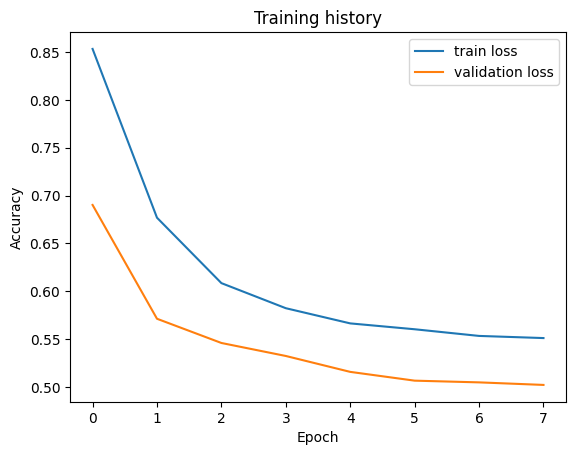

In [25]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

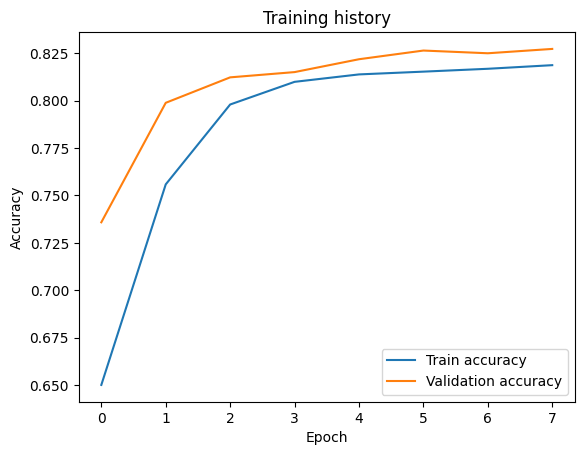

In [26]:
training_accuracy = [acc.item() for acc in history['train_accuracy']]
validation_accuracy = [acc.item() for acc in history['val_accuracy']]
plt.plot(training_accuracy, label='Train accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

### Model-3
Repeating the steps followed during Model-1.

**Model-3**: 
**Hyperparameters Discussion**: The validation accuracy for Model 2 is approximately 83%, which is about lower than that of Model 1. However,
I believe the model can achieve higher accuracy given the utilization of features from the pre-trained BERT model. Consequently, I decided to experiment with adjusting a few hyperparameters. In this model, the BERT model configuration remains the same as the first model, with the last 4 layers unfrozen. Here, we have utilized the Model 2 architecture after changing the dropout of the first dropout layer to 0.3. Additionally, on top of the Model 2 configuration, a fully connected layer of size (64,32) was added, followed by a normalization layer, a dropout of 0.3, and a ReLU layer. Finally, the last layer of the model is a fully connected layer of size (32,3) used for classification. For this model, we reduced the dropout to 0.3 from 0.4 with the hope that it would assist the model in extracting more relevant features and, in turn, improve the model’s accuracy.
Furthermore, the max token length value was adjusted to 130 to explore whether this modification would yield better results, especially considering the decrease in accuracy for Model 2 compared to Model 1. Additionally, to assess different batch size configurations, the batch size was decreased back to 32. Adhering to the requirement for Mini Batch Gradient Descent, the training of the model followed this procedure. The initial learning rate of 0.001 was deliberately kept low to ensure effective learning, and the learning rate was updated in every epoch. I decided to increase the number of epochs to 12 for Model 2, as the accuracy declined with 8 epochs. This adjustment aims
to evaluate if the model performs better with a greater number of epochs

In [27]:
# Load the requried dataset
train_data = pd.read_csv('yelp_review_train.csv')
test_data = pd.read_csv('yelp_review_test.csv')

In [28]:
# Function to pre-process text 
def data_preprocessing(text):
    # Remove HTML tags and special characters from the text field 
    text = re.sub('<[^<]+?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization of the text fields and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply pre-processing to the 'text' column
train_data['text'] = train_data['text'].apply(data_preprocessing)
test_data['text'] = test_data['text'].apply(data_preprocessing)

# Convert stars to three levels
train_data['sentiment'] = train_data['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))
test_data['sentiment'] = test_data['stars'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x <= 2 else 'Neutral'))

# Define Level names
levels = ['Negative', 'Neutral', 'Positive']
# Mapping dictionary for sentiment labels
level_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}

# Convert sentiment column to integers based on the mapping
train_data['sentiment'] = train_data['sentiment'].map(level_mapping)
test_data['sentiment'] = test_data['sentiment'].map(level_mapping)

In [29]:
# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate token lengths
token_lens = [len(tokenizer.encode(txt, max_length=512, truncation=True)) for txt in train_data.text]

# Display mean and median values
mean_length = np.mean(token_lens)
median_length = np.median(token_lens)
max_length = np.max(token_lens)
min_length = np.min(token_lens)
print(f"Mean Token Length: {mean_length}")
print(f"Median Token Length: {median_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")

Mean Token Length: 64.82734311071945
Median Token Length: 47.0
Maximum Token Length: 512
Minimum Token Length: 3


In [30]:
# Defining MAX_LEN globally
MAX_LEN = 130

# Creating a class for processing the data
class processdata(Dataset):
    
    def __init__(self,text,targets,tokenizer,max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self,item):
        review = str(self.text[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review, add_special_tokens=True, max_length=self.max_len, return_token_type_ids=False,
            padding='max_length', truncation=True,
            return_attention_mask=True,
            return_tensors='pt',)
        
        return {'review_text': review, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}
    
    def __len__(self):
        return len(self.text)

    

In [31]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict = False)


class classifier(nn.Module):
    def __init__(self, n_classes, freeze_layers=4):  # Assuming BERT has 12 layers
        super(classifier, self).__init__()
        self.bert = bert_model
        
        # Freeze BERT layers
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Unfreeze the last `freeze_layers` layers
        for layer in self.bert.encoder.layer[-freeze_layers:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        self.drop = nn.Dropout(p=0.3)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.layer_norm1 = nn.LayerNorm(128) 
        self.drop1 = nn.Dropout(p=0.3)
        self.relu1 = nn.ReLU()
        
        # Additional layers
        self.out2 = nn.Linear(128, 64)
        self.layer_norm2 = nn.LayerNorm(64)
        self.drop2 = nn.Dropout(p=0.4)
        self.relu2 = nn.ReLU()
        
        self.out3 = nn.Linear(64, 32)  # Additional layer of size 32
        self.layer_norm3 = nn.LayerNorm(32)
        self.drop3 = nn.Dropout(p=0.3)
        self.relu3 = nn.ReLU()
        
        self.out4 = nn.Linear(32, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # First layer
        output = self.drop(pooled_output)
        output = self.out1(output)
        output = self.relu1(output)
        output = self.drop1(output)
        
        # Additional layers
        output = self.out2(output)
        output = self.layer_norm2(output)
        output = self.relu2(output)
        output = self.drop2(output)
        
        output = self.out3(output)
        output = self.layer_norm3(output)
        output = self.relu3(output)
        output = self.drop3(output)
        
        return self.out4(output)



In [32]:
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)
test_set = test_data

def dataloader(df,tokenizer,max_len,batch_size):
    datal = processdata(
        text = df.text.to_numpy(), 
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(datal,batch_size=batch_size,num_workers=4)

BATCH_SIZE = 32
train_data_loader = dataloader(train_set, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = dataloader(val_set, tokenizer, MAX_LEN, BATCH_SIZE)

model3 = classifier(len(levels))
model3 = model3.to(device)
total_epochs = 12
optimizer = torch.optim.SGD(model3.parameters(), lr=0.001)
total_steps = len(train_data_loader) * total_epochs
loss_scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_function = nn.CrossEntropyLoss().to(device)

In [33]:
def training(model3,data_loader,loss_function,optimizer, device,loss_scheduler, examples):
    model3 = model3.train()
    losses = []
    model_prediction = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model3(
            input_ids=input_ids,
            attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs,targets)

        model_prediction += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1.0)
        optimizer.step()
        loss_scheduler.step()
        optimizer.zero_grad()

    return model_prediction.double() / examples, np.mean(losses)

def eval_model3(model3, data_loader, loss_function,device, examples):
    model3 = model3.eval()
    losses = []
    model_prediction = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model3(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)
            model_prediction += torch.sum(preds == targets)
            losses.append(loss.item())
    return model_prediction.double() / examples, np.mean(losses)


In [34]:
history = defaultdict(list)

for epoch in range(total_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{total_epochs}')
    print('-' * 20)

    # Training
    train_accuracy, train_loss = training(
        model3,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        loss_scheduler,
        len(train_set)
    )
    print(f'Training Loss {train_loss} Accuracy {train_accuracy}')

    # Validation
    val_accuracy, val_loss = eval_model3(
        model3,
        val_data_loader,
        loss_function,
        device,
        len(val_set)
    )
    print(f'Validation Loss {val_loss} Accuracy {val_accuracy}')

    # Calculate and print epoch running time
    epoch_time = time.time() - start_time
    print(f'Epoch time: {epoch_time:.2f} seconds')

    print()
    history['train_accuracy'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss)

# Save the final validation accuracy for model3
model3 = model3
model3_final_val_accuracy = val_accuracy
model3_name = 'model3'


Epoch 1/12
--------------------
Training Loss 0.8357700586496324 Accuracy 0.6649046886735095
Validation Loss 0.6448844929190808 Accuracy 0.770485236896315
Epoch time: 467.64 seconds

Epoch 2/12
--------------------
Training Loss 0.6617824161631152 Accuracy 0.7701226708629877
Validation Loss 0.5681518949397856 Accuracy 0.811655985351339
Epoch time: 468.51 seconds

Epoch 3/12
--------------------
Training Loss 0.6071358358329317 Accuracy 0.8039626622796038
Validation Loss 0.5512911346890135 Accuracy 0.8152037079423209
Epoch time: 468.40 seconds

Epoch 4/12
--------------------
Training Loss 0.5865702699826385 Accuracy 0.8124316011587568
Validation Loss 0.5312423876470529 Accuracy 0.8294232089723049
Epoch time: 469.91 seconds

Epoch 5/12
--------------------
Training Loss 0.5675593246022633 Accuracy 0.8189478201781052
Validation Loss 0.5228645719335587 Accuracy 0.8212119478141451
Epoch time: 468.83 seconds

Epoch 6/12
--------------------
Training Loss 0.5567286390581838 Accuracy 0.823010

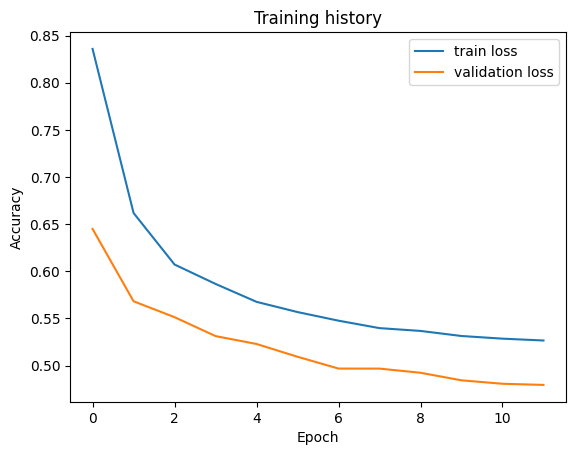

In [35]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


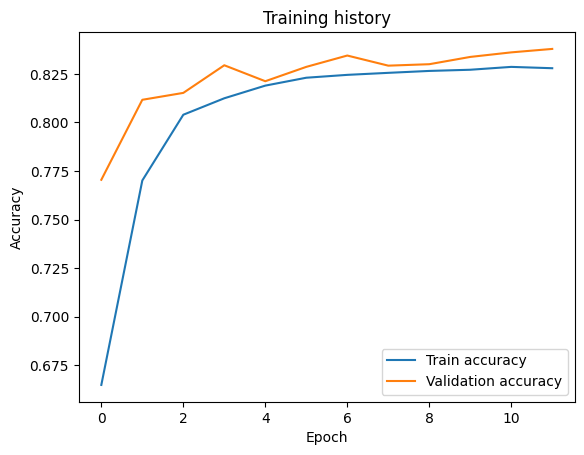

In [36]:
training_accuracy = [acc.item() for acc in history['train_accuracy']]
validation_accuracy = [acc.item() for acc in history['val_accuracy']]
plt.plot(training_accuracy, label='Train accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [2]:
# Comparing the accuracies of the three models.

In [37]:
# Create an array to store model names and their final validation accuracies
model_results = [
    {'name': model1_name, 'val_accuracy': model1_final_val_accuracy},
    {'name': model2_name, 'val_accuracy': model2_final_val_accuracy},
    {'name': model3_name, 'val_accuracy': model3_final_val_accuracy}
]

# Choose the model with the highest validation accuracy
best_model_result = max(model_results, key=lambda x: x['val_accuracy'])
best_model_name = best_model_result['name']
best_model_val_accuracy = best_model_result['val_accuracy']


print(f"The best model is {best_model_name} with a validation accuracy of {best_model_val_accuracy}")

The best model is model1 with a validation accuracy of 0.8434996566720073


In [38]:
# Use the MaxLen of the best model that is Model 1, hence, setting it to 120
#Setting model as model1 for testing
model = model1
MAX_LEN = 120
test_data_loader = dataloader(test_set, tokenizer, MAX_LEN, BATCH_SIZE)
test_acc, _ = eval_model1(model1,test_data_loader,loss_function, device,len(test_set))
test_acc.item()

0.8414163090128756

In [39]:
def func_result(model, data_loader):
    model = model.eval()
    review_texts = []
    final_predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            final_predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    final_predictions = torch.stack(final_predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, final_predictions, prediction_probs, real_values

In [40]:
y_review_texts, y_pred, y_pred_probs, y_test = func_result(model,test_data_loader)
print(classification_report(y_test, y_pred, target_names=levels))

              precision    recall  f1-score   support

    Negative       0.76      0.85      0.81      3145
     Neutral       0.45      0.08      0.13      1416
    Positive       0.88      0.95      0.91      9419

    accuracy                           0.84     13980
   macro avg       0.70      0.63      0.62     13980
weighted avg       0.81      0.84      0.81     13980



In [3]:
# Confusion Matrix

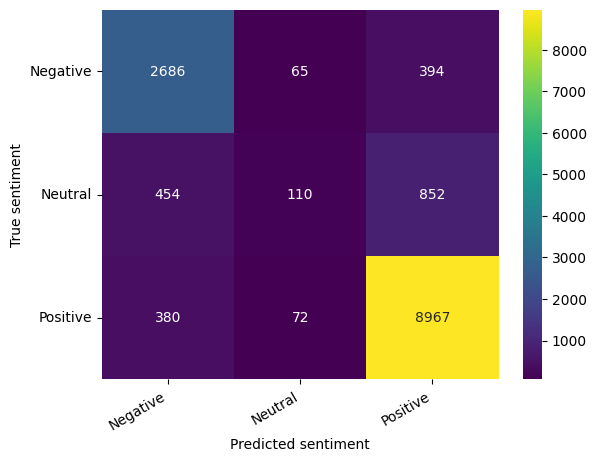

In [43]:
# Plot Confusion Matrix
def display_confusion_matrix(conf_matrix):
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    plt.show()


conf_matrix = confusion_matrix(y_test, y_pred)
labels = levels  # Assuming 'levels' is defined
df_conf_matrix = pd.DataFrame(conf_matrix, index=labels, columns=labels)
display_confusion_matrix(df_conf_matrix)
